# Maps of time-mean variables

## Import the libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Standard library
import multiprocessing.popen_spawn_posix

# Data analysis and viz libraries
import dask
import matplotlib.colors as mcol
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
from matplotlib.offsetbox import AnchoredText

In [3]:
import aeolus.plot as aplt

In [4]:
# Local modules
import mypaths
import names
from calc import bond_albedo, dry_lapse_rate, integral, meridional_mean, spatial_mean, zonal_mean
from commons import MODELS
from load_thai import LOAD_CONF
from model_exocam import calc_pres_exocam
from plot_func import (
    KW_AUX_TTL,
    KW_AXGR,
    KW_CBAR_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    XLOCS,
    darr_stats_string,
    draw_scalar,
    draw_vector,
    figsave,
    linspace_pm1,
    make_map_figure,
    set_alpha_in_cmap,
)

In [5]:
plt.style.use("paper.mplstyle")

## Choose case

In [6]:
THAI_case = "Hab2"

## Constants

Define atmospheric and planetary constants. Note the planet's radius is in meters!

In [7]:
if THAI_case.endswith("1"):
    import const_ben1_hab1 as const
else:
    import const_ben2_hab2 as const

## Load the data

Load the time-averaged data previously preprocessed.

In [8]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# for each of the THAI cases, create a nested directory for models
datasets[THAI_case] = {}
for model_key in LOAD_CONF.keys():
    datasets[THAI_case][model_key] = xr.open_dataset(
        mypaths.datadir / model_key / f"{THAI_case}_regridded_time_mean_{model_key}.nc"
    )

In [9]:
for model_key in LOAD_CONF.keys():
    print(
        model_key,
        np.round(float(bond_albedo(datasets[THAI_case][model_key], model_key)), 2),
    )

ExoCAM 0.15
LMDG 0.21
ROCKE3D 0.19
UM 0.16


In [10]:
# model_key = "ROCKE3D"
# model_names = getattr(names, model_key.lower())
# ds = datasets[THAI_case][model_key]

In [11]:
# pres = spatial_mean(ds[model_names.pres])
# if model_key != "ROCKE3D":
#     # Pa to hPa
#     pres /= 1e2
# lons = ds[model_names.x]

## Longitude profiles of tropospheric mean variables

### Temperature and specific humidity

In [16]:
VARIABLES = {
    "temp": {
        "tex_units": "$K$",
        "title": "Air temperature",
        "func": lambda ds, mk: ds[getattr(names, mk.lower()).temp],
        "lim": [250, 285],
    },
    "sh": {
        "tex_units": "$kg$ $kg^{-1}$",
        "title": "Specific humidity",
        "func": lambda ds, mk: ds[getattr(names, mk.lower()).sh],
        "lim": [0, 0.0060],
    },
}

In [17]:
def extract_troposphere(arr, alt, zcoord, thresh=15e3):
    """Extract tropospheric values from a data array."""
    out = xr.where(alt < thresh, arr, np.nan).dropna(zcoord)
    return out

Text(0.5, 1.0, 'Hab2')

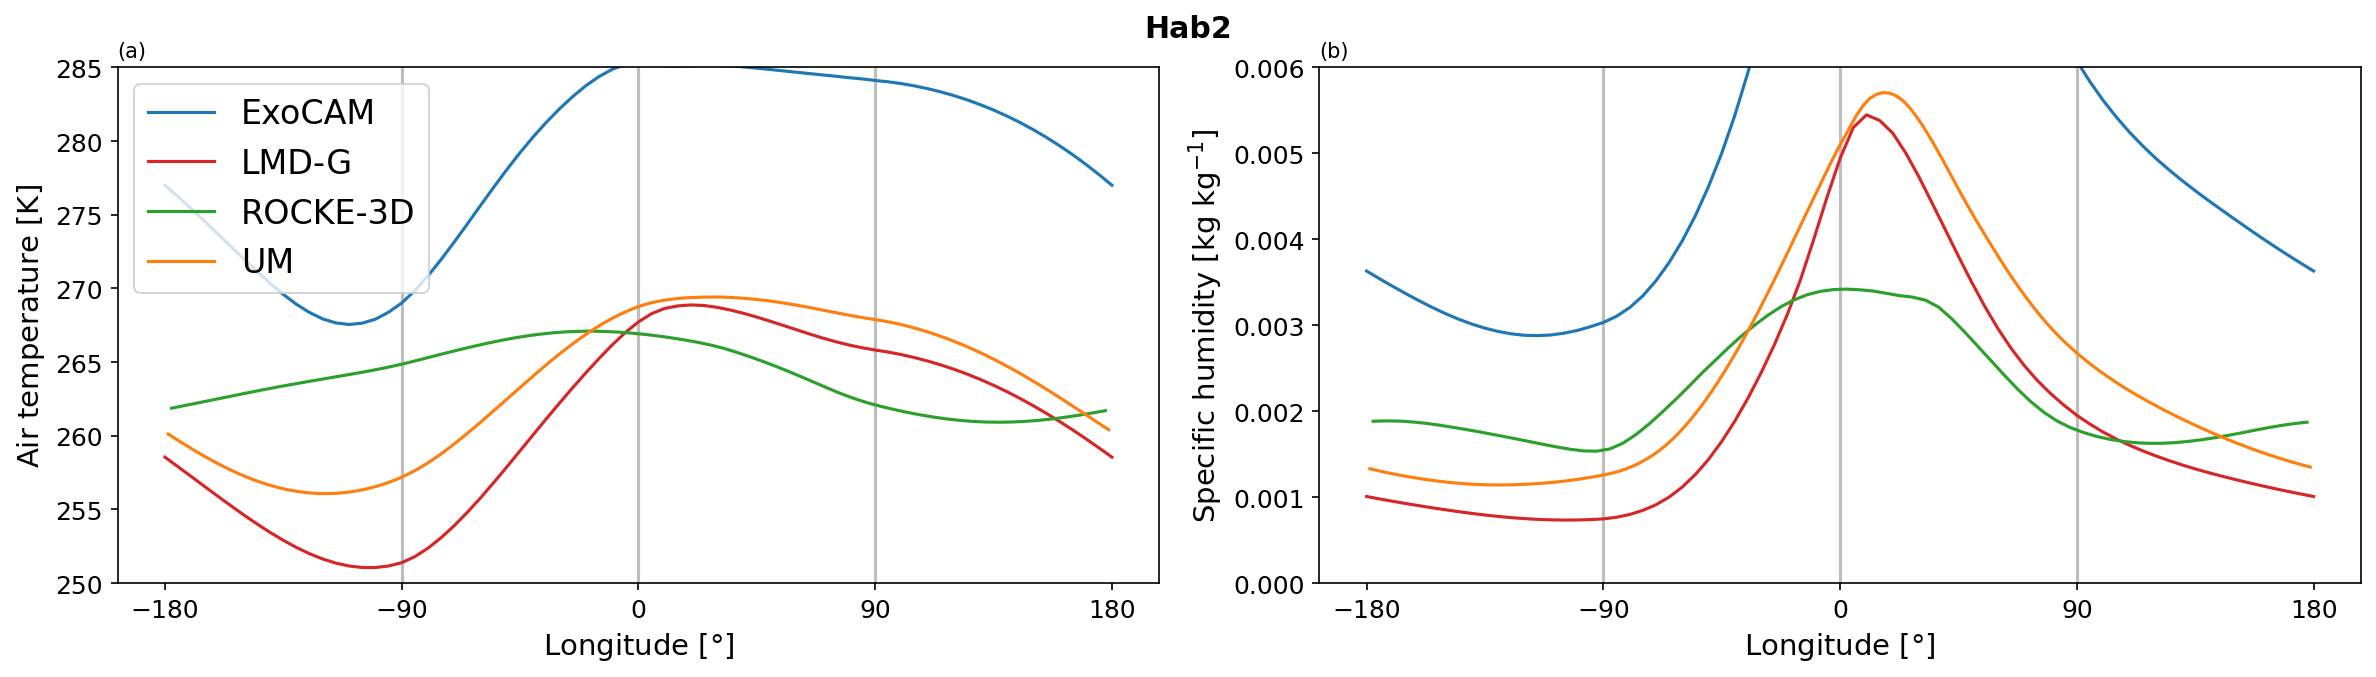

In [19]:
reduce = meridional_mean
case = THAI_case
ncols = len(VARIABLES)
nrows = 1

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 8, nrows * 4.5))
iletters = aplt.subplot_label_generator()
for ax, (varkey, vardict) in zip(axs.flat, VARIABLES.items()):
    ax.set_title(f"({next(iletters)})", **KW_SBPLT_LABEL)
    ax.set_xticks(XLOCS)
    ax.set_ylim(vardict["lim"])
    for ix in XLOCS[1:-1]:
        ax.vlines(ix, *vardict["lim"], color="tab:grey", alpha=0.5)
    # if ax.is_first_col():
    ax.set_ylabel(f"{vardict['title']} [{vardict['tex_units']}]")
    if ax.is_last_row():
        ax.set_xlabel("Longitude [$\degree$]")

    for model_key, model_dict in MODELS.items():
        model_names = getattr(names, model_key.lower())
        ds = datasets[case][model_key]

        if model_key == "ExoCAM":
            pres = ds[model_names.pres]
            alt = ds[model_names.z]
            kw_z = dict(
                coord=alt,
                dim=model_names.lev,
            )
        elif model_key == "LMDG":
            pres = ds[model_names.pres]
            alt = ds[model_names.lev]
            kw_z = dict(
                coord=alt,
                dim=model_names.z,
            )
        elif model_key == "ROCKE3D":
            pres = ds[model_names.pres] * 1e2
            alt = ds[model_names.z]
            kw_z = dict(
                coord=alt,
                dim=model_names.lev,
            )
        elif model_key == "UM":
            pres = ds[model_names.pres]
            alt = ds[model_names.z]
            kw_z = dict(dim=model_names.z)
        rho = pres / (ds[model_names.temp] * const.rgas)
        arr = vardict["func"](ds, model_key)
        thresh = 20e3
        rho = extract_troposphere(rho, alt, kw_z["dim"], thresh=thresh)
        arr = extract_troposphere(arr, alt, kw_z["dim"], thresh=thresh)
        if "coord" in kw_z:
            kw_z["coord"] = extract_troposphere(alt, alt, kw_z["dim"], thresh=thresh)
        

        arr = integral(arr * rho, **kw_z) / integral(rho, **kw_z)
        arr = reduce(arr)
        ax.plot(arr[model_names.x], arr, color=model_dict["color"], label=model_dict["title"])
axs.flatten()[0].legend(loc="upper left");
fig.tight_layout()
fig.suptitle(f"{case}", y=1.0, fontweight="bold")
# figsave(
#         fig,
#         mypaths.plotdir / f"{THAI_case}__x__trop_mean_{'_'.join(VARIABLES.keys())}",
#     )

In [15]:
# TROP_LAPSE_THRESH = -2e-3  # [K m-1]

# a = xr.where((ds[model_names.z] > 7e3) & (dry_lapse_rate(ds, model_key) > TROP_LAPSE_THRESH), ds[model_names.z], np.nan)

# a.dropna(model_names.lev)

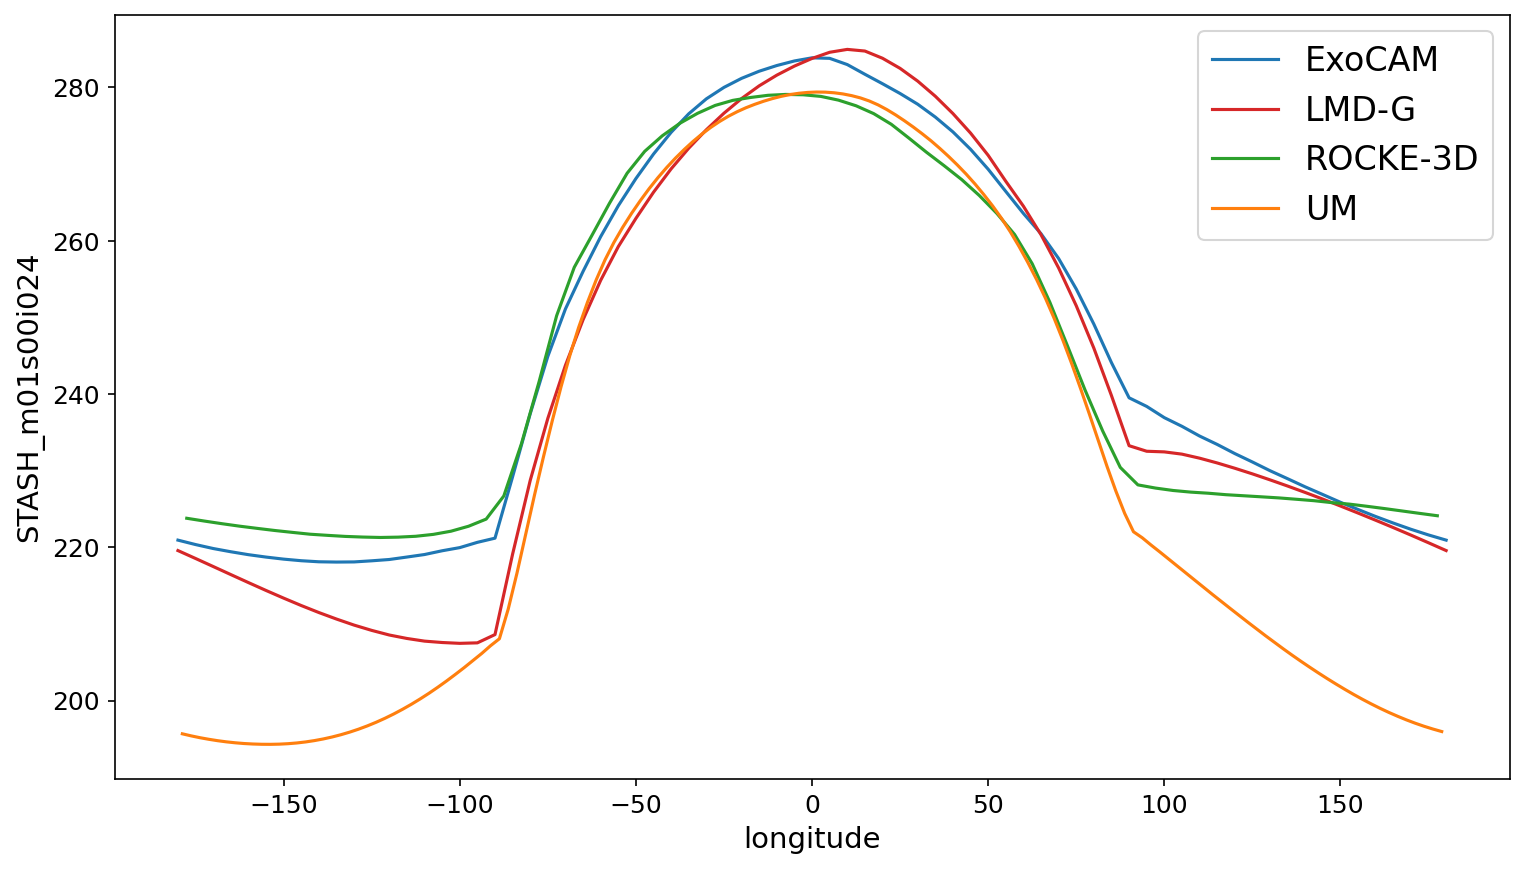

In [11]:
for model_key, model_dict in MODELS.items():
    ds = datasets[THAI_case][model_key]
    darr = extract_sfc_temp(ds, model_key, THAI_case, const)

    # a = darr.sel(latitude=0, method="nearest")
    a = meridional_mean(darr)
    a.plot(color=model_dict["color"], label=model_dict["title"])
plt.legend();

## Pressure-longitude cross-sections

In [10]:
def cloud_volume_fraction(ds, model_key):
    """Extract cloud fraction on levels from a THAI dataset."""
    model_names = getattr(names, model_key.lower())
    if model_key == "ROCKE3D":
        out = ds[model_names.cld_ice_v] + ds[model_names.cld_ice_v]
    else:
        out = ds[model_names.cld_v]
    return out * 100


def cloud_volume_fraction_ice(ds, model_key):
    """Extract ice cloud fraction on levels from a THAI dataset."""
    model_names = getattr(names, model_key.lower())
    if model_key == "ExoCAM":
        out = ds[model_names.cld_v]
    elif model_key == "LMDG":
        out = ds[model_names.cld_v]
    else:
        out = ds[model_names.cld_ice_v]
    return out * 100


def cloud_volume_fraction_liq(ds, model_key):
    """Extract liquid cloud fraction on levels from a THAI dataset."""
    model_names = getattr(names, model_key.lower())
    if model_key == "ExoCAM":
        out = ds[model_names.cld_v]
    elif model_key == "LMDG":
        out = ds[model_names.cld_v]
    else:
        out = ds[model_names.cld_liq_v]
    return out * 100


def cloud_mmr_ice(ds, model_key):
    """Extract ice cloud MMR on levels from a THAI dataset."""
    model_names = getattr(names, model_key.lower())
    if model_key == "LMDG":
        t_min = 258
        t_max = 273
        scaling = (np.clip(ds[model_names.temp], t_min, t_max) - t_min) / (
            t_max - t_min
        )
        out = ds[model_names.cld_ice_mf] * (1 - scaling)
    else:
        out = ds[model_names.cld_ice_mf]
    return out


def cloud_mmr_liq(ds, model_key):
    """Extract liquid cloud MMR on levels from a THAI dataset."""
    model_names = getattr(names, model_key.lower())
    if model_key == "LMDG":
        t_min = 258
        t_max = 273
        scaling = (np.clip(ds[model_names.temp], t_min, t_max) - t_min) / (
            t_max - t_min
        )
        out = ds[model_names.cld_ice_mf] * scaling
    else:
        out = ds[model_names.cld_liq_mf]
    return out

### Regular cross-sections


In [22]:
def plot_pres_lon_cross(case, vardict):
    ncols = 2
    nrows = 2

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 8, nrows * 4.5))
    iletters = aplt.subplot_label_generator()
    for model_key, ax in zip(MODELS.keys(), axs.flat):
        model_names = getattr(names, model_key.lower())
        ax.set_title(model_key, **KW_MAIN_TTL)
        ax.set_title(f"({next(iletters)})", **KW_SBPLT_LABEL)
        ax.set_ylim(1000, 0)
        ax.set_xticks(XLOCS)
        for ix in XLOCS[1:-1]:
            ax.vlines(ix, 1000, 0, color="tab:grey", alpha=0.5)
        if ax.is_first_col():
            ax.set_ylabel("Pressure [$hPa$]")
        if ax.is_last_row():
            ax.set_xlabel("Longitude [$\degree$]")

        pres = spatial_mean(datasets[case][model_key][model_names.pres])
        if model_key != "ROCKE3D":
            # Pa to hPa
            pres /= 1e2
        lons = datasets[case][model_key][model_names.x]
        arr = vardict["func"](datasets[case][model_key], model_key)  # , case, const)
        arr = meridional_mean(arr)

        h = getattr(ax, vardict["method"])(
            lons,
            pres,
            arr,
            **vardict["kw_plt"],
        )
    fig.tight_layout()
    fig.suptitle(f"{case}", y=0.999, fontweight="bold")
    cb = fig.colorbar(h, ax=axs, orientation="horizontal", aspect=60, pad=0.1)
    cb.set_label(f"{vardict['title']} [{vardict['tex_units']}]")
    return fig

In [15]:
VARIABLES = {
    #     "temp": {
    #         "tex_units": "$K$",
    #         "title": "Air temperature",
    #         "func": lambda ds, mk, *args: ds[getattr(names, mk.lower()).temp],
    #         "method": "pcolormesh",
    #         "kw_plt": dict(cmap="viridis", vmin=200, vmax=300),
    #     },
    #    "dt_lw": {
    #         "tex_units": "$K$ $day^{-1}$",
    #         "title": "LW heating rate",
    #         "func": lambda ds, mk, *args: ds[getattr(names, mk.lower()).dt_lw],
    #         "method": "pcolormesh",
    #         "kw_plt": dict(cmap="coolwarm"),
    #     },
    #     "dt_sw": {
    #         "tex_units": "$K$ $day^{-1}$",
    #         "title": "SW heating rate",
    #         "func": lambda ds, mk, *args: ds[getattr(names, mk.lower()).dt_sw],
    #         "method": "pcolormesh",
    #         "kw_plt": dict(cmap="coolwarm"),
    #     },
    "cld_v": {
        "tex_units": "%",
        "title": "Cloud fraction",
        "func": cloud_volume_fraction,
        "method": "contourf",
        "kw_plt": dict(cmap="Purples", levels=np.linspace(0, 100, 11)),
    },
}

cld_v
Saved to ../plots/Hab1__px__cld_v.png


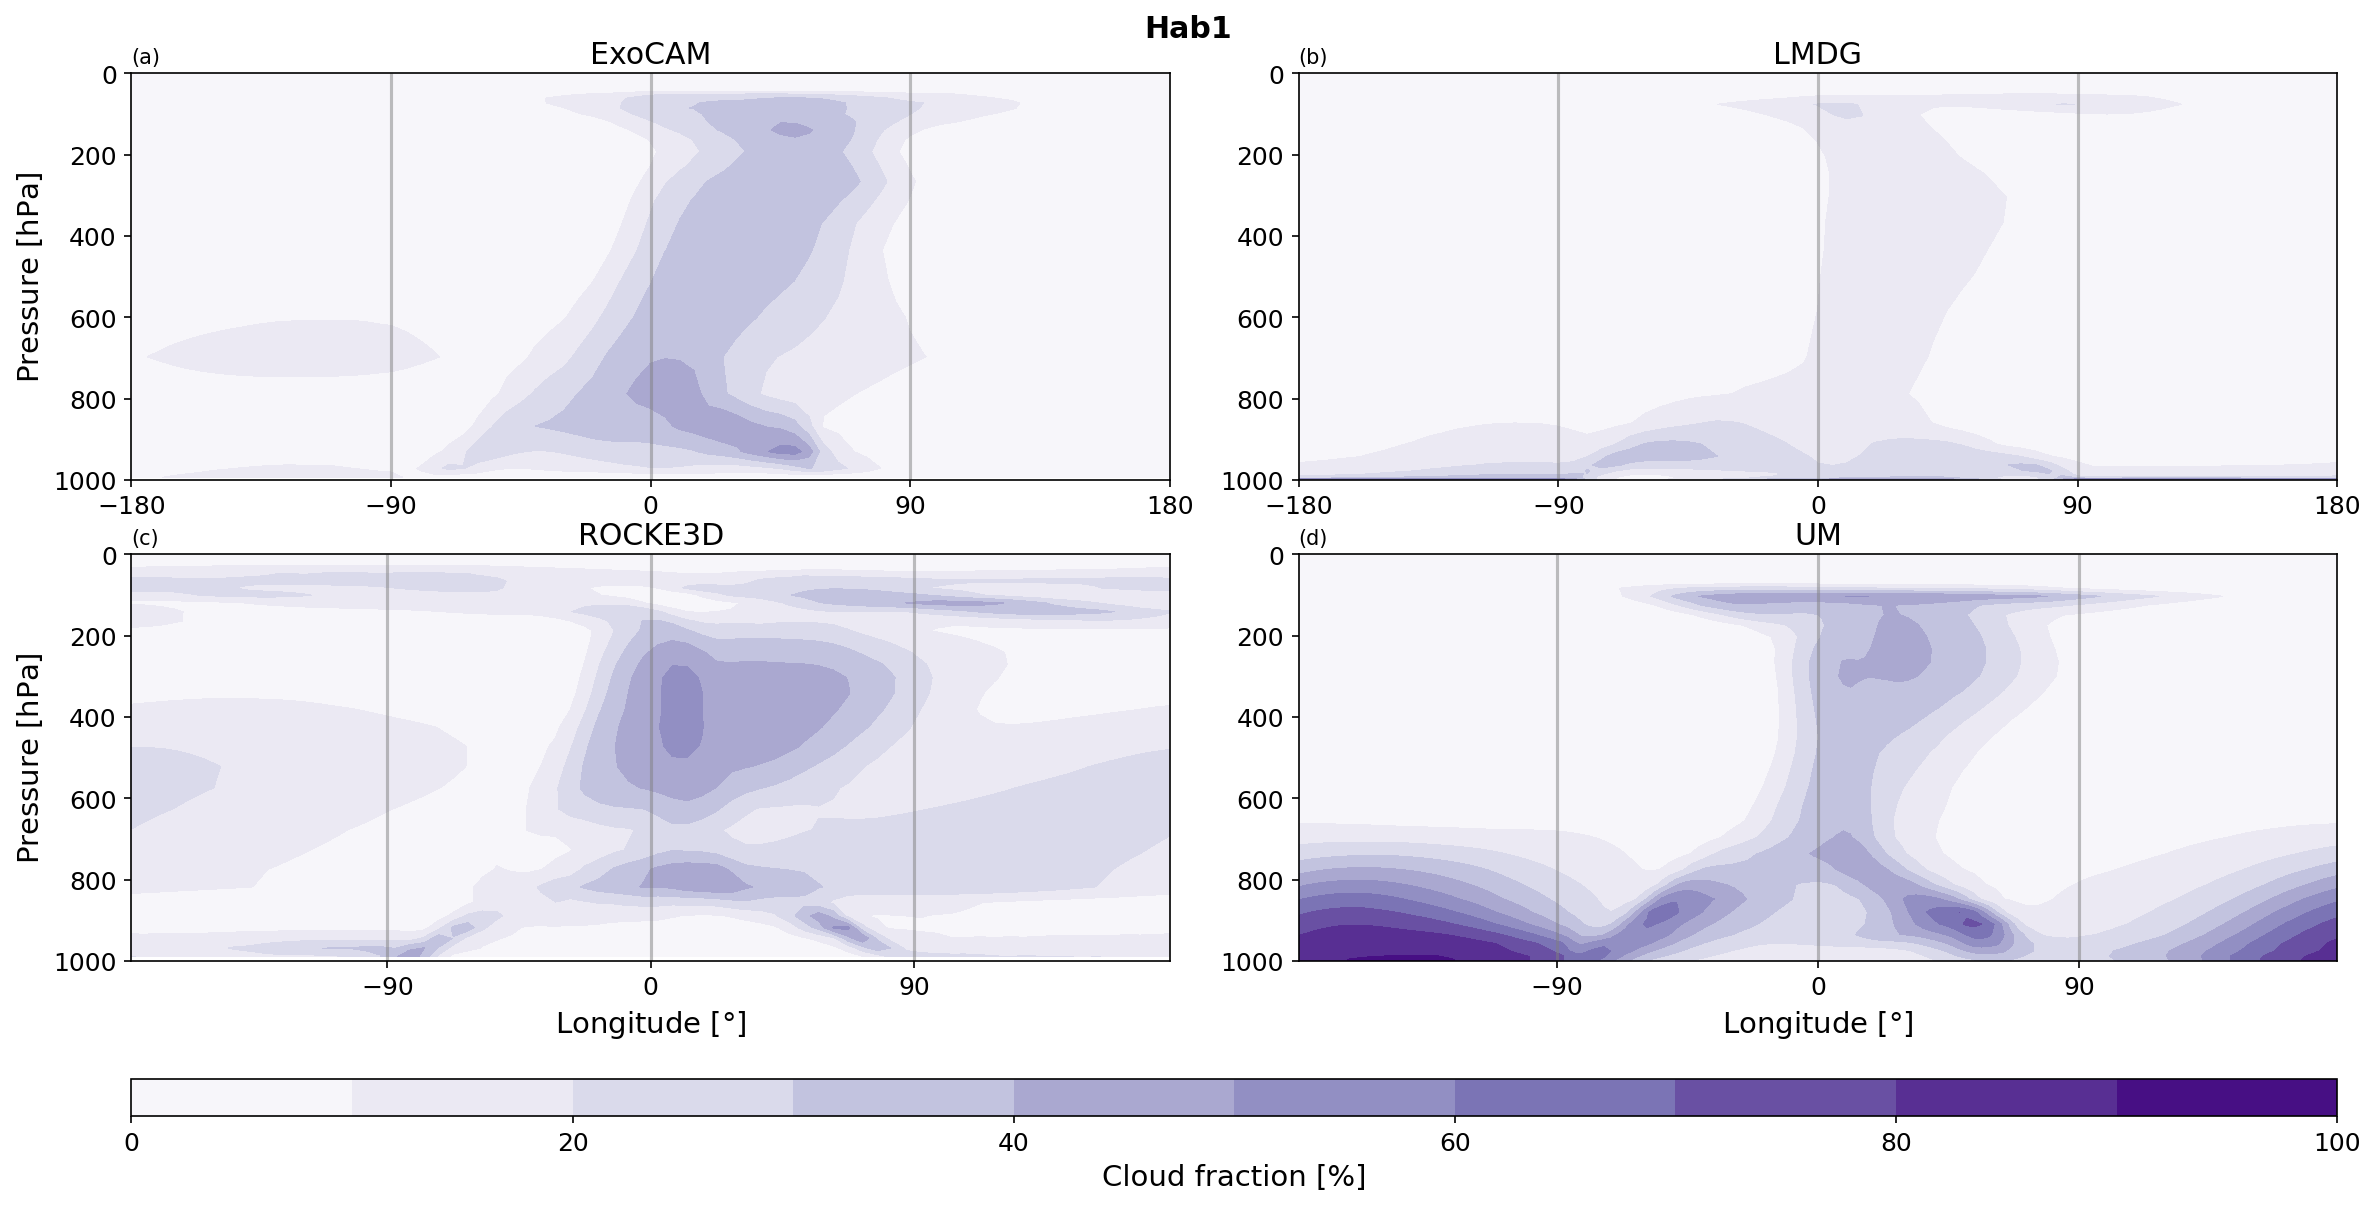

In [123]:
for varkey, vardict in VARIABLES.items():
    print(varkey)
    fig = plot_pres_lon_cross(THAI_case, vardict)
    figsave(
        fig,
        mypaths.plotdir / f"{THAI_case}__px__{varkey}",
    )

### Special case: liquid and ice cloud MMRs

Text(0.5, 1.08, 'Hab1\nMeridional mean cloud cross-sections\nTop: cloud mass mixing ratio: liquid [log($kg$ $kg^{-1}$)] and ice [log($kg$ $kg^{-1}$)]\nBottom: cloud fraction [%]')

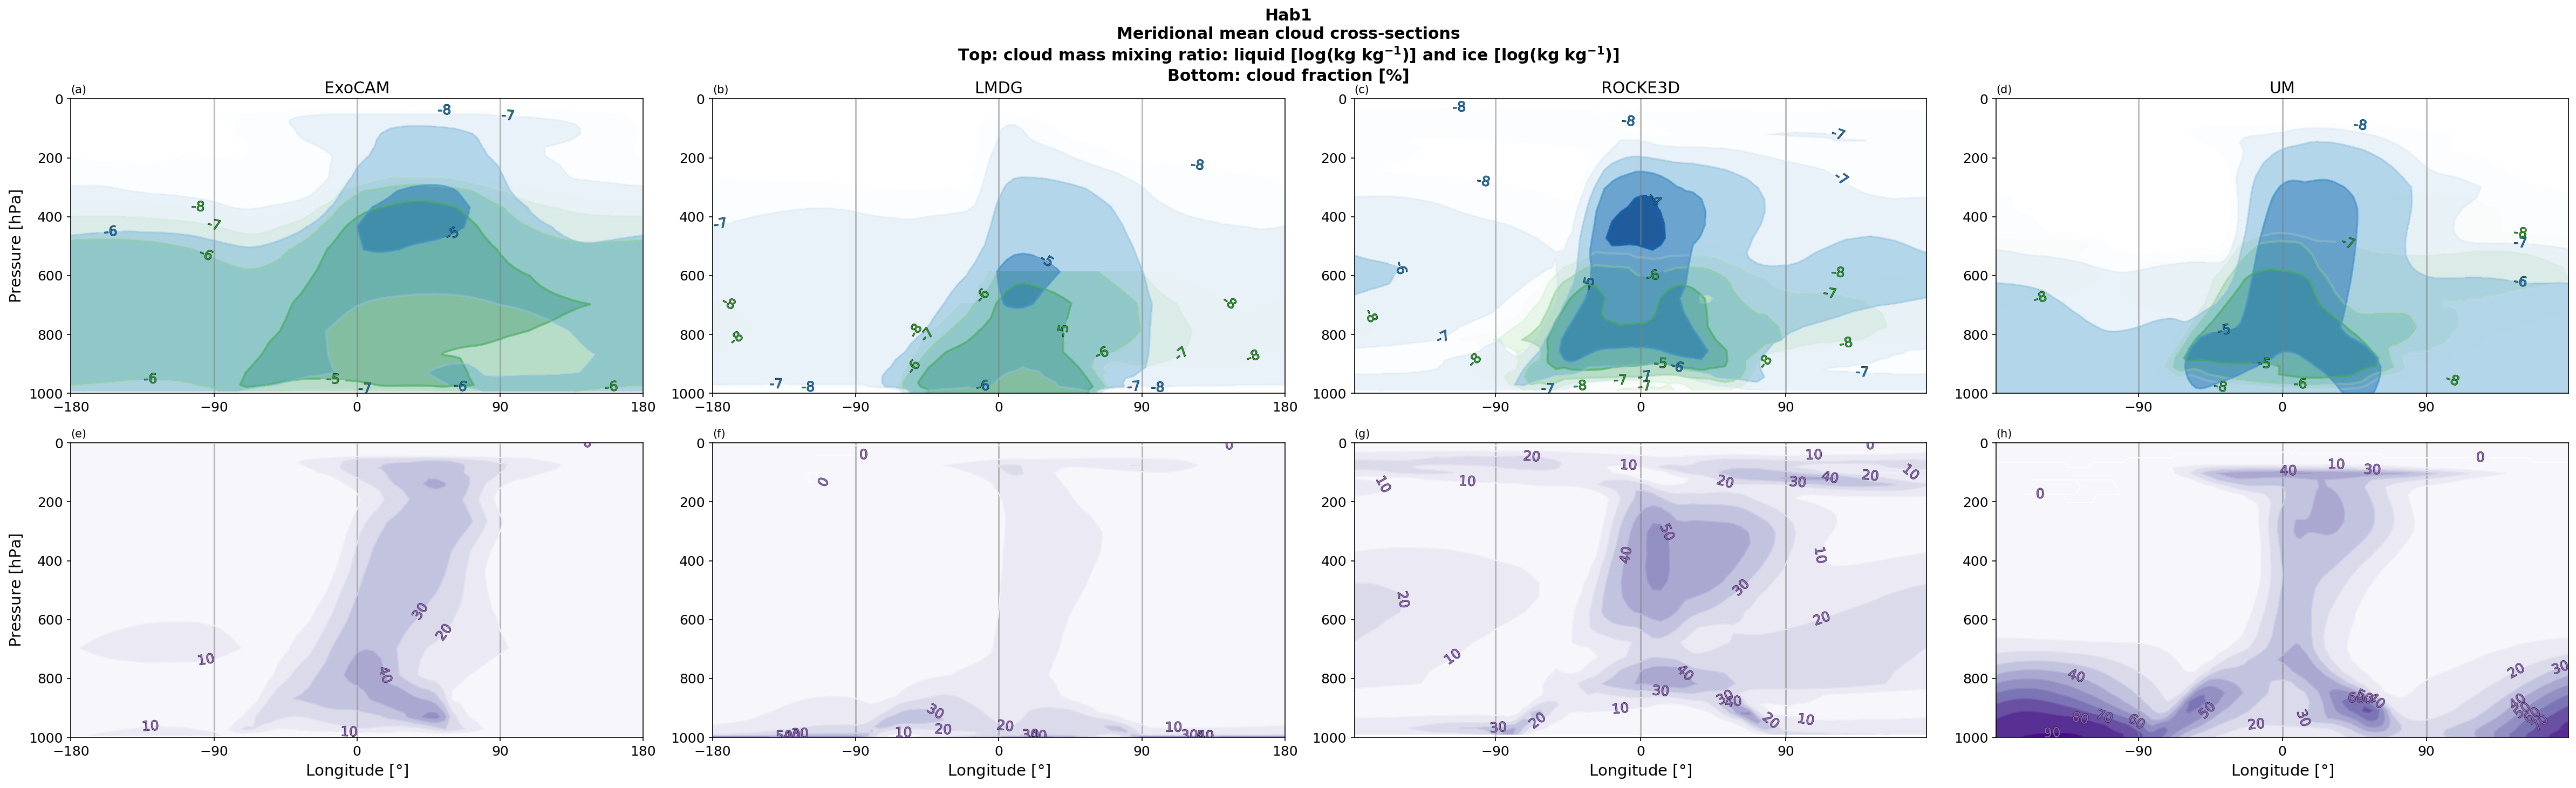

In [20]:
# reduce = lambda a: a.sel(latitude=0, method="nearest")
reduce = meridional_mean
case = THAI_case
ncols = 4
nrows = 2

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 8, nrows * 4.5))
iletters = aplt.subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"({next(iletters)})", **KW_SBPLT_LABEL)
    ax.set_ylim(1000, 0)
    # ax.set_yscale("log")
    ax.set_xticks(XLOCS)
    for ix in XLOCS[1:-1]:
        ax.vlines(ix, 1000, 0, color="tab:grey", alpha=0.5)
    if ax.is_first_col():
        ax.set_ylabel("Pressure [$hPa$]")
    if ax.is_last_row():
        ax.set_xlabel("Longitude [$\degree$]")

axrow = axs[0, :]
for model_key, ax in zip(MODELS.keys(), axrow):
    model_names = getattr(names, model_key.lower())
    ax.set_title(model_key, **KW_MAIN_TTL)
    pres = spatial_mean(datasets[case][model_key][model_names.pres])
    if model_key != "ROCKE3D":
        # Pa to hPa
        pres /= 1e2
    lons = datasets[case][model_key][model_names.x]
    cld_liq = cloud_mmr_liq(datasets[case][model_key], model_key)
    cld_ice = cloud_mmr_ice(datasets[case][model_key], model_key)

    for arr, levs, cmap, color in zip(
        [cld_liq, cld_ice],
        # [np.linspace(1, 10, 10), np.linspace(1, 10, 10) * 10],
        [np.linspace(-8, -3, 6), np.linspace(-8, -3, 6)],
        ["Greens", "Blues"],
        ["tab:green", "tab:blue"],
    ):
        arr = reduce(arr)
        cntrf = ax.contourf(
            lons,
            pres,
            np.log10(arr),
            cmap=set_alpha_in_cmap(cmap),
            levels=levs,
            extend="both",
        )
        cntr = ax.contour(
            lons,
            pres,
            np.log10(arr),
            cmap=set_alpha_in_cmap(cmap),
            levels=levs,
            extend="both",
            linewidths=2,
        )
        clbls = ax.clabel(cntr, colors=color, fmt="%.0f")
        plt.setp(
            clbls,
            path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="k")],
        )

axrow = axs[1, :]
vardict = VARIABLES["cld_v"]
for model_key, ax in zip(MODELS.keys(), axrow):
    model_names = getattr(names, model_key.lower())
    pres = spatial_mean(datasets[case][model_key][model_names.pres])
    if model_key != "ROCKE3D":
        # Pa to hPa
        pres /= 1e2
    lons = datasets[case][model_key][model_names.x]
    arr = vardict["func"](datasets[case][model_key], model_key)  # , case, const)
    arr = reduce(arr)

    cntrf = getattr(ax, vardict["method"])(
        lons,
        pres,
        arr,
        **vardict["kw_plt"],
    )
    cntr = ax.contour(
        lons,
        pres,
        arr,
        **vardict["kw_plt"],
        linewidths=1,
    )
    clbls = ax.clabel(cntr, colors="tab:purple", fmt="%.0f")
    plt.setp(
        clbls,
        path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="k")],
    )
fig.tight_layout()
ttl = (
    "Meridional mean cloud cross-sections\n"
    r"Top: cloud mass mixing ratio: liquid [log($kg$ $kg^{-1}$)] and ice [log($kg$ $kg^{-1}$)]"
    f"\nBottom: {vardict['title'].lower()} [{vardict['tex_units']}]"
)
fig.suptitle(f"{case}\n{ttl}", y=1.08, fontweight="bold")
# figsave(
#         fig,
#         mypaths.plotdir / f"{THAI_case}__px__cld_ice_liq_mmr_cld_v",
#     )

## Maps

In [10]:
def sfc_net_up_lw_flux(ds, model_key, case, const):
    r"""
    Calculate the net downward longwave radiative flux at the surface.

    Parameters
    ----------
    ds: xarray.Dataset
        Input dataset containing relevant variables.
    model_key: str,
        Model name.

    Returns
    -------
    xarray.DataArray
    """
    model_names = getattr(names, model_key.lower())
    if model_key == "ExoCAM":
        out = ds[model_names.sfc_net_down_lw]
    elif model_key == "LMDG":
        out = -ds[model_names.sfc_net_down_lw]
    elif model_key == "ROCKE3D":
        out = -(ds[model_names.sfc_dn_lw] - ds[model_names.sfc_up_lw])
    elif model_key == "UM":
        out = -ds[model_names.sfc_net_down_lw]
    return out


def extract_cwp(ds, model_key, case, const):
    """Extract cloud water path from a THAI dataset."""
    model_names = getattr(names, model_key.lower())
    if model_key in ["ExoCAM", "ROCKE3D"]:
        # input in [g m-2]
        out = (ds[model_names.lwp] + ds[model_names.iwp]) / 1000
    elif model_key == "LMDG":
        out = ds[model_names.cwp]
    elif model_key == "UM":
        out = ds[model_names.lwp] + ds[model_names.iwp]
    return out


def extract_sfc_temp(ds, model_key, case, const):
    """Extract surface temperature from a THAI dataset."""
    model_names = getattr(names, model_key.lower())
    out = ds[model_names.t_sfc]
    if model_key == "ROCKE3D":
        out = out.copy() + const.t_melt  # convert from degC to K
    return out


def sfc_dn_lw_flux(ds, model_key, case, const):
    """Calculate the downward longwave radiative flux at the surface."""
    net_flux = sfc_net_up_lw_flux(ds, model_key, case, const)
    up_flux = const.stefan_boltzmann * extract_sfc_temp(ds, model_key, case, const) ** 4
    return up_flux - net_flux

In [9]:
KW_AXGR = dict(
    axes_pad=(0.6, 0.8),
    cbar_location="bottom",
    cbar_mode="single",
    cbar_pad=0.005,
    cbar_size="4%",
    label_mode="",
)

In [10]:
def plot_maps(case, vardict):
    ncols = 2
    nrows = 2

    fig, axgr = make_map_figure(ncols, nrows, **KW_AXGR)
    cax = axgr.cbar_axes[0]
    fig.suptitle(f"{case}", y=0.925, fontweight="bold")

    for model_key, ax in zip(LOAD_CONF.keys(), axgr.axes_all):
        model_names = getattr(names, model_key.lower())
        ax.set_title(model_key, **KW_MAIN_TTL)
        arr = vardict["func"](datasets[case][model_key], model_key, case, const)
        h = draw_scalar(
            arr,
            ax,
            method=vardict["method"],
            cbar_ticks=None,
            use_cyclic=False,
            model_names=model_names,
            **vardict["kw_plt"],
        )
        ax.add_artist(
            AnchoredText(
                darr_stats_string(arr, model_names.x, model_names.y),
                loc="lower center",
                bbox_to_anchor=(0.5, -0.3),
                bbox_transform=ax.transAxes,
                prop={"backgroundcolor": "white", "color": "black", "size": "medium"},
            )
        )
    cb = fig.colorbar(h, cax=cax, orientation="horizontal")
    cb.set_label(f"{vardict['title']} [{vardict['tex_units']}]")
    return fig

In [39]:
VARIABLES = {
    #     "sfc_net_up_lw_flux": {
    #         "tex_units": "$W$ $m^{-2}$",
    #         "title": "Net upward LW radiation flux at the surface",
    #         "func": sfc_net_up_lw_flux,
    #         "method": "pcolormesh",
    #         "kw_plt": dict(cmap="coolwarm", vmin=-75, vmax=75),
    #     },
    #     "sfc_dn_lw_flux": {
    #         "tex_units": "$W$ $m^{-2}$",
    #         "title": "Downward LW radiation flux at the surface",
    #         "func": sfc_dn_lw_flux,
    #         "method": "pcolormesh",
    #         "kw_plt": dict(cmap="viridis", vmin=100, vmax=400),
    #     },
    #     "sfc_dn_sw_flux": {
    #         "tex_units": "$W$ $m^{-2}$",
    #         "title": "Downward SW radiation flux at the surface",
    #         "func": lambda ds, model_key, case, const: ds[getattr(names, model_key.lower()).sfc_dn_sw],
    #         "method": "pcolormesh",
    #         "kw_plt": dict(cmap="viridis", vmin=0, vmax=400),
    #     },
    "t_sfc": {
        "tex_units": "$K$",
        "title": "Surface temperature",
        "func": extract_sfc_temp,
        "method": "pcolormesh",
        "kw_plt": dict(cmap="viridis", vmin=273.15, vmax=300),
    },
    #     "cwp": {
    #         "tex_units": "$kg$ $m^{-2}$",
    #         "title": "Cloud water path",
    #         "func": extract_cwp,
    #         "method": "pcolormesh",
    #         "kw_plt": dict(cmap="Blues_r", norm=mcol.LogNorm(vmin=1e-3, vmax=1e0)),
    #     }
}

t_sfc
Saved to ../plots/Hab1__xy__t_sfc.png


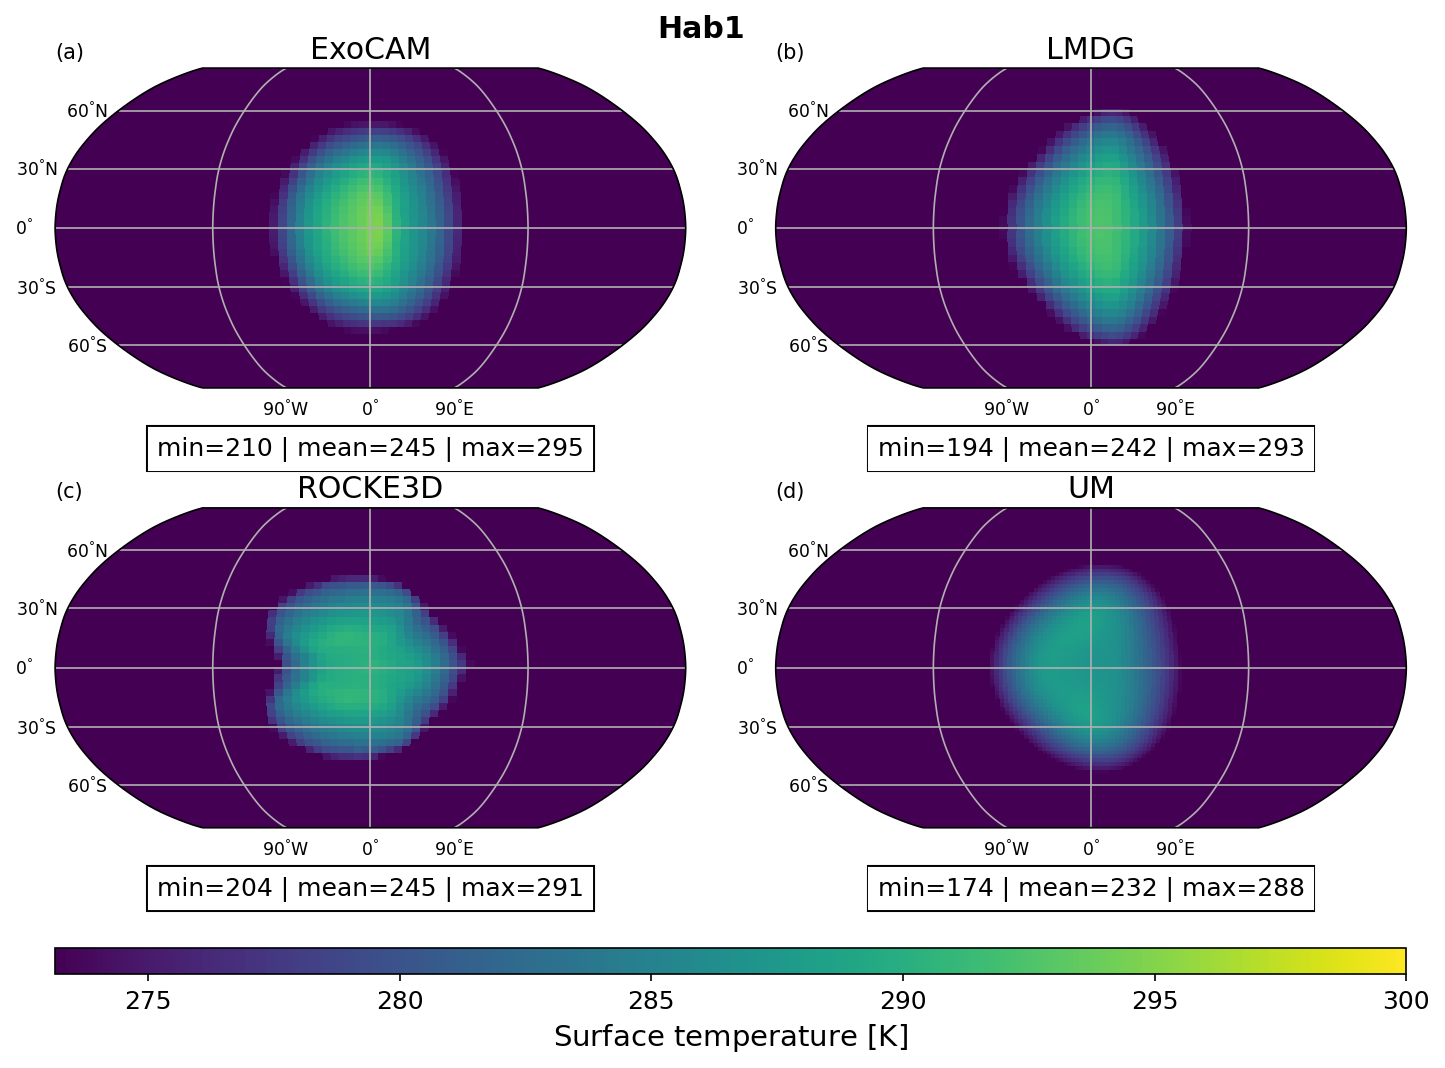

In [40]:
for varkey, vardict in VARIABLES.items():
    print(varkey)
    fig = plot_maps(THAI_case, vardict)
    figsave(
        fig,
        mypaths.plotdir / f"{THAI_case}__xy__{varkey}",
    )